# PetFinder Feature Engineering -Mahmood

In [4]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_columns', None)

In [2]:
train_df = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/train/train.csv')
test_df = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/test/test.csv')
color_df = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/ColorLabels.csv')
breed_df = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/BreedLabels.csv')

In [5]:
train_df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [6]:
# basic features : if its a mix of both breed, it will be 2 else 1.
train_df['num_breed'] = ((train_df['Breed1'] > 0) & (train_df['Breed2'] > 0)).astype(int) + ((train_df['Breed1'] > 0) | (train_df['Breed2'] > 0)).astype(int)
test_df['num_breed'] = ((test_df['Breed1'] > 0) & (test_df['Breed2'] > 0)).astype(int) + ((test_df['Breed1'] > 0) | (test_df['Breed2'] > 0)).astype(int)


In [8]:
# same with number of colors 
color_columns = ['Color1', 'Color2', 'Color3']
train_df['num_colors'] = (train_df[color_columns] > 0).sum(axis=1)
test_df['num_colors'] = (test_df[color_columns] > 0).sum(axis=1)


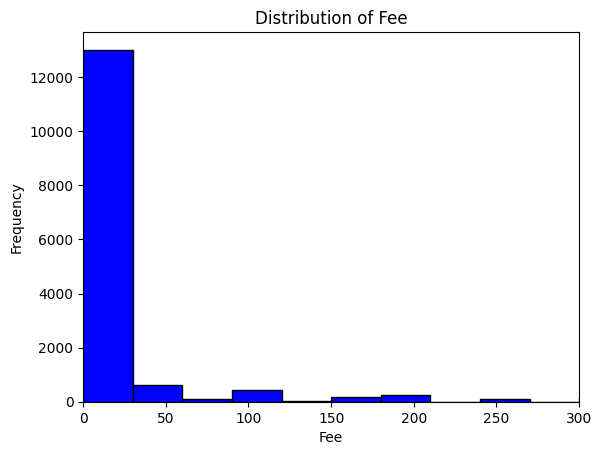

In [16]:
# lets do something with fee 
import matplotlib.pyplot as plt
# distribution of fee
plt.hist(train_df['Fee'], bins=100, color='blue', edgecolor='black')
plt.title('Distribution of Fee')
plt.xlabel('Fee')
plt.ylabel('Frequency')
plt.xlim(0,300)
plt.show()


In [17]:
# using vaccinated, dewormed, health and sterilized features
train_df['Total_Vaccinations'] = train_df[['Vaccinated', 'Dewormed', 'Sterilized']].sum(axis=1)
test_df['Total_Vaccinations'] = test_df[['Vaccinated', 'Dewormed', 'Sterilized']].sum(axis=1)

train_df['Avg_Health_Score'] = train_df[['Health']].mean(axis=1)
test_df['Avg_Health_Score'] = test_df[['Health']].mean(axis=1)

In [19]:
# feature using fur length and health

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# creating interaction feature
train_df['Fur_Health_Interact'] = train_df['FurLength'].astype(str) + '_' + train_df['Health'].astype(str)
# Fit and transform the column
train_df['Fur_Health_Interact_Encoded'] = label_encoder.fit_transform(train_df['Fur_Health_Interact'])

test_df['Fur_Health_Interact'] = test_df['FurLength'].astype(str) + '_' + test_df['Health'].astype(str)
# Fit and transform the column
test_df['Fur_Health_Interact_Encoded'] = label_encoder.fit_transform(test_df['Fur_Health_Interact'])

In [21]:
# feature using health
def feature_eng_health_vaccinated(df):

    conditions = [
        (df['Health'] == 1) & (df['Total_Vaccinations'] == 0),
        (df['Health'] == 1) & (df['Total_Vaccinations'] > 0),
        (df['Health'].isin([2, 3]))
    ]
    choices = ['Healthy and Unvaccinated', 'Healthy and Vaccinated', 'Injured or Sick']
    df['Overall_Health_Status'] = np.select(conditions, choices, default='Not Specified')
    df['Overall_Health_Status_Encoded'] = label_encoder.fit_transform(df['Overall_Health_Status'])
    
    return df

train_df = feature_eng_health_vaccinated(train_df)
test_df = feature_eng_health_vaccinated(test_df)


In [24]:
# arranging the column order
new_column_order = ['PetID'] + [col for col in train_df.columns if col != 'PetID' and col != 'AdoptionSpeed'] + ['AdoptionSpeed']
train_df_new_order = train_df[new_column_order]


In [31]:
if 'AdoptionSpeed' in test_df.columns:
    new_column_order = ['PetID'] + [col for col in test_df.columns if col != 'PetID' and col != 'AdoptionSpeed'] + ['AdoptionSpeed']
    test_df = test_df[new_column_order]
else:
    new_column_order = ['PetID'] + [col for col in test_df.columns if col != 'PetID']
    test_df = test_df[new_column_order]

In [33]:
test_df.shape

(3972, 31)

In [36]:
# saving the files
train_df_new_order.to_csv('train_df_mahmood_features.csv')
test_df.to_csv('test_df_mahmood_features.csv')